# Reasoning without Observation

White Paper: https://arxiv.org/pdf/2305.18323

Agent that combines a multi-step planner and variable substitution for effective tool use. 
It was designed to improve on the ReACT-style agent architecture in the following ways:

1) Reduce token consumption and execution time by generating the full chain of tools used in a single pass. 
ReACT-style agent architecture requires many LLM calls with redundant prefixes 
(since the system prompt and previous steps are provided to the LLM for each reasoning step)
2) Simplify the fine-tuning process. 
Since the planning data doesn't depend on the outputs of the tool, models can be fine-tuned without actually invoking the tools (in theory).

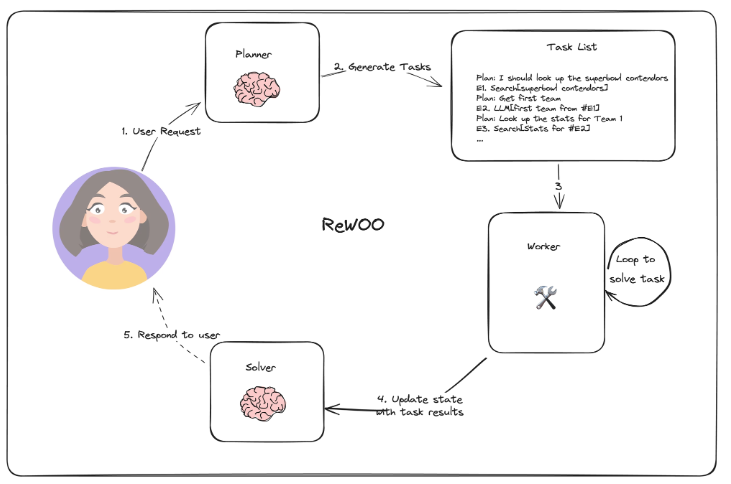

ReWOO is made of 3 modules:

🧠Planner: Generate the plan in the following format:
```
Plan: <reasoning>
#E1 = Tool[argument for tool]
Plan: <reasoning>
#E2 = Tool[argument for tool with #E1 variable substitution]
```

Worker: executes the tool with the provided arguments.
🧠Solver: generates the answer for the initial task based on the tool observations.
The modules with a 🧠 emoji depend on an LLM call. Notice that we avoid redundant calls to the planner LLM by using variable substitution.

Sample LangSmith Trace: https://smith.langchain.com/public/39dbdcf8-fbcc-4479-8e28-15377ca5e653/r


# 0. Prerequisites

For this example, we will provide the agent with a Tavily search engine tool. You can get an API key here or replace with a free tool option (e.g., duck duck go search).

In [1]:
# %pip install -U langgraph langchain_community langchain_openai tavily-python

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Reasoning_without_Observation"

### Graph State: 
 
In LangGraph, every node updates a shared graph state. The state is the input to any node whenever it is invoked.

Below, we will define a state dict to contain the task, plan, steps, and other variables.

In [3]:
from typing import List, TypedDict


class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

# 1. Planner



The planner prompts an LLM to generate a plan in the form of a task list. 

The arguments to each task are strings that may contain special variables (#E{0-9}+) that are used for variable substitution from other task results.

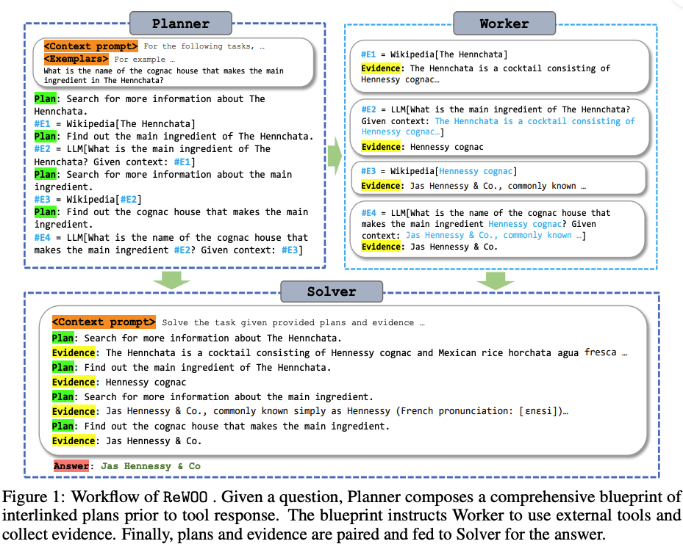

Our example agent will have two tools:

1. Google - a search engine (in this case Tavily)
2. LLM - an LLM call to reason about previous outputs.
The LLM tool receives less of the prompt context and so can be more token-efficient than the ReACT paradigm.

In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini",temperature=0)

In [5]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin! 
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""

In [6]:
task = "what is the hometown of the 2024 australian open winner"

In [7]:
result = model.invoke(prompt.format(task=task))

In [8]:
print(result.content)

To determine the hometown of the 2024 Australian Open winner, I will follow a series of steps to gather the necessary information.

Plan: First, I will search for the winner of the 2024 Australian Open. This will provide the name of the player who won the tournament. #E1 = Google["2024 Australian Open winner"]

Plan: Once I have the name of the winner, I will look up their biography or profile to find information about their hometown. This will help me identify where the winner is from. #E2 = Google["hometown of #E1"]

Plan: If necessary, I will verify the information about the winner's hometown by checking multiple sources to ensure accuracy. #E3 = Google["#E2 verification of hometown of #E1"] 

By following these steps, I will be able to accurately determine the hometown of the 2024 Australian Open winner.


# Planner Node
To connect the planner to our graph, we will create a get_plan node that accepts the ReWOO state and returns with a state update for the steps and plan_string fields.

In [9]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*([^([^([^]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model


def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

# 2. Executor

The executor receives the plan and executes the tools in sequence.

Below, instantiate the search engine and define the tool execution node.

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()

In [11]:
def _get_current_task(state: ReWOO):
    if state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = state["results"] or {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = model.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}

# 3. Solver

The solver receives the full plan and generates the final response based on the responses of the tool calls from the worker.



In [12]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = state["results"] or {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    return {"result": result.content}


# 4. Define Graph
Our graph defines the workflow. Each of the planner, tool executor, and solver modules are added as nodes.

In [13]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

In [14]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

In [15]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'plan_string': 'To determine the hometown of the 2024 Australian Open winner, I will follow a series of steps to gather the necessary information.\n\nPlan: First, I will search for the winner of the 2024 Australian Open. This will provide the name of the player who won the tournament. #E1 = Google["2024 Australian Open winner"]\n\nPlan: Once I have the name of the winner, I will look up their biography or profile to find out their hometown. This will give me the specific location associated with the player. #E2 = Google["hometown of #E1"]\n\nPlan: If necessary, I will verify the information about the player\'s hometown by checking multiple sources to ensure accuracy. #E3 = Google["#E2 verification of hometown"] \n\nBy following these steps, I will be able to accurately identify the hometown of the 2024 Australian Open winner.', 'steps': []}}
---


IndexError: list index out of range